# VCC Public API Exploration

This notebook explores the Virginia Connected Corridor (VCC) Public API v3.1.

## API Overview

- **Base URL**: https://vcc.vtti.vt.edu
- **Authentication**: JWT (JSON Web Tokens)
- **Message Types**: BSM, MapData, SPAT, PSM
- **Encoding**: SAE J2735 2016-03 (binary, base64-encoded) and JSON formats


In [2]:
!pip install -r requirements-vcc.txt

  Using cached websockets-15.0.1-cp312-cp312-win_amd64.whl.metadata (7.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 3.4 MB/s eta 0:00:03
   ----- ---------------------------------- 1.0/8.1 MB 2.8 MB/s eta 0:00:03
   ------ --------------------------------- 1.3/8.1 MB 2.8 MB/s eta 0:00:03
   ------- -------------------------------- 1.6/8.1 MB 2.2 MB/s eta 0:00:04
   --------- ------------------------------ 1.8/8.1 MB 1.9 MB/s eta 0:00:04
   ---------- ----------------------------- 2.1/8.1 MB 1.8 MB/s eta 0:00:04
   ------------ --------------------------- 2.6/8.1 MB 1.8 MB/s eta 0:00:04
   -------------- ------------------------- 2.9/8.1 MB 1.7 MB/s eta 0:00:03
   -------------- ------------------------- 2.9/8.1 MB 1.7 MB/s eta 0:00:03
   --------------- ------------------------ 3.1/8.1 MB 1.6 MB/s eta 0:00:04
   ------------------ --------------------- 3.7/8.1 MB 1.5 MB/s eta 0:00:03
   ---------------

In [3]:
# Import required libraries
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import base64
from datetime import datetime
import asyncio
import websockets

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('ggplot')
%matplotlib inline

## 1. Authentication

The VCC API uses OAuth2 with JSON Web Tokens (JWT) for authentication. You need:

- `client_id`: Your unique client identifier
- `client_secret`: Your secret key

client_id: course-cs6604-student-djjay
client_secret: wHqQjvksKE6rYLYedkuIqewrFtEOpjHH

**Note**: Replace the placeholders below with your actual credentials.


In [4]:
# Configuration
BASE_URL = "https://vcc.vtti.vt.edu"
TOKEN_URL = f"{BASE_URL}/api/auth/client"

# TODO: Replace with your actual credentials
CLIENT_ID = 'course-cs6604-student-djjay'
CLIENT_SECRET = 'wHqQjvksKE6rYLYedkuIqewrFtEOpjHH'
# Request JWT token


def get_access_token():
    """Request a JWT access token using client credentials"""
    data = {
        'client_id': CLIENT_ID,
        'client_secret': CLIENT_SECRET
    }

    try:
        response = requests.post(TOKEN_URL, data=data, allow_redirects=False)
        response.raise_for_status()
        token_data = response.json()
        access_token = token_data.get('access_token')
        expires_in = token_data.get('expires_in')

        print(f"✓ Access token obtained")
        print(
            f"  Expires in: {expires_in} seconds ({expires_in/60:.1f} minutes)")
        return access_token
    except requests.exceptions.RequestException as e:
        print(f"✗ Failed to get access token: {e}")
        return None


# Get token and create headers
access_token = get_access_token()
headers = {'Authorization': f'Bearer {access_token}'} if access_token else {}

✓ Access token obtained
  Expires in: 36000 seconds (600.0 minutes)


## 2. MapData API

MapData messages describe intersection lane geometry, including:

- Lane positions and connections
- Speed limits
- Signal group associations


In [5]:
# Get list of all MapData (decoded/JSON format)
def get_all_mapdata():
    """Retrieve all MapData messages in JSON format"""
    url = f"{BASE_URL}/api/mapdata/decoded"
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        data = response.json()
        print(f"✓ Retrieved {len(data)} MapData messages")
        return data
    except requests.exceptions.RequestException as e:
        print(f"✗ Failed to get MapData: {e}")
        return []


mapdata_list = get_all_mapdata()

# Create summary DataFrame
if mapdata_list:
    summary_data = []
    for md in mapdata_list:
        if 'intersections' in md and len(md['intersections']) > 0:
            intersection = md['intersections'][0]
            summary_data.append({
                'Intersection ID': intersection['id']['id'],
                'Revision': intersection['revision'],
                'Latitude': intersection['refPoint']['lat'],
                'Longitude': intersection['refPoint']['lon'],
                'Lane Count': len(intersection.get('laneSet', [])),
                'Lane Width (m)': intersection.get('laneWidth')
            })

    df_mapdata = pd.DataFrame(summary_data)
    display(df_mapdata.head(10))

✓ Retrieved 4 MapData messages


,Intersection ID,Revision,Latitude,Longitude,Lane Count,Lane Width (m)
0,156,3,38.928411,-77.241071,33,3.66
1,158,4,38.920952,-77.233830,21,3.66
2,159,4,38.918318,-77.230614,23,3.66
3,3837,1,37.187012,-80.395026,8,3.66


In [6]:
# Get specific intersection MapData
INTERSECTION_ID = 152  # Example intersection


def get_mapdata_by_id(intersection_id):
    """Retrieve MapData for a specific intersection"""
    url = f"{BASE_URL}/api/mapdata/{intersection_id}/decoded"
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        data = response.json()
        print(f"✓ Retrieved MapData for intersection {intersection_id}")
        return data
    except requests.exceptions.RequestException as e:
        print(f"✗ Failed to get MapData: {e}")
        return None


mapdata_152 = get_mapdata_by_id(INTERSECTION_ID)

if mapdata_152 and 'intersections' in mapdata_152:
    intersection = mapdata_152['intersections'][0]
    print(f"\nIntersection Details:")
    print(f"  ID: {intersection['id']['id']}")
    print(
        f"  Location: ({intersection['refPoint']['lat']:.6f}, {intersection['refPoint']['lon']:.6f})")
    print(f"  Lanes: {len(intersection['laneSet'])}")
    print(f"  Lane Width: {intersection.get('laneWidth', 'N/A')} meters")

✓ Retrieved MapData for intersection 152

Intersection Details:
  ID: 152
  Location: (38.862981, -77.227696)
  Lanes: 25
  Lane Width: 3.66 meters


### Visualize Lane Geometry


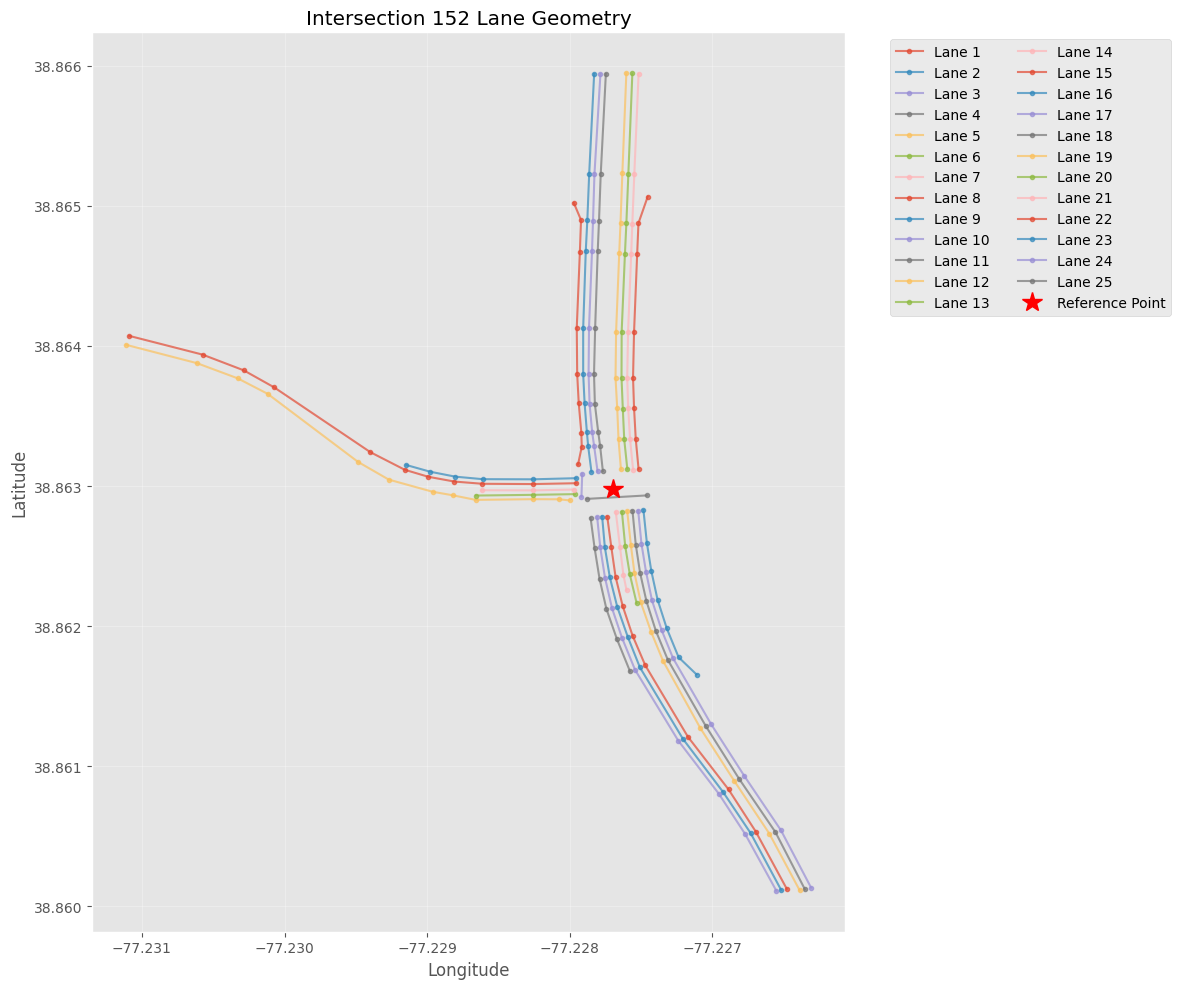

In [7]:
# Plot intersection lanes
if mapdata_152 and 'intersections' in mapdata_152:
    intersection = mapdata_152['intersections'][0]
    ref_lat = intersection['refPoint']['lat']
    ref_lon = intersection['refPoint']['lon']

    plt.figure(figsize=(12, 10))

    for lane in intersection['laneSet']:
        lane_id = lane['laneID']
        nodes = lane['nodesList'].get('nodes', [])

        if nodes:
            lats = [node['delta']['lat'] for node in nodes]
            lons = [node['delta']['lon'] for node in nodes]

            plt.plot(lons, lats, marker='o', markersize=3,
                     label=f'Lane {lane_id}', alpha=0.7)

    plt.plot(ref_lon, ref_lat, 'r*', markersize=15, label='Reference Point')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Intersection {INTERSECTION_ID} Lane Geometry')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 3. SPAT API

SPAT (Signal Phase and Timing) messages provide real-time traffic signal information:

- Current signal state (red, yellow, green)
- Time until next change
- Signal group information


In [8]:
# Get latest SPAT for all intersections
def get_latest_spat():
    """Retrieve latest SPAT for all intersections"""
    url = f"{BASE_URL}/api/spat?format=JSON_COMPLETE"
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        data = response.json()
        print(f"✓ Retrieved {len(data)} SPAT messages")
        return data
    except requests.exceptions.RequestException as e:
        print(f"✗ Failed to get SPAT: {e}")
        return []


spat_messages = get_latest_spat()

# Parse and display SPAT data
if spat_messages:
    spat_data = []
    for spat_str in spat_messages[:5]:  # Show first 5
        try:
            spat = json.loads(spat_str)
            if 'intersections' in spat:
                for intersection in spat['intersections']:
                    int_id = intersection['id']['id']
                    for state in intersection.get('states', []):
                        signal_group = state['signalGroup']
                        if state.get('stateTimeSpeed'):
                            event = state['stateTimeSpeed'][0]
                            event_state = event['eventState']

                            # State mapping
                            state_map = {
                                0: 'unavailable', 1: 'dark', 2: 'stop-then-proceed',
                                3: 'stop-and-remain', 4: 'pre-movement',
                                5: 'permissive-green', 6: 'protected-green',
                                7: 'permissive-yellow', 8: 'protected-yellow',
                                9: 'caution'
                            }

                            spat_data.append({
                                'Intersection': int_id,
                                'Signal Group': signal_group,
                                'State': state_map.get(event_state, f'unknown({event_state})')
                            })
        except json.JSONDecodeError:
            continue

    if spat_data:
        df_spat = pd.DataFrame(spat_data)
        display(df_spat.head(20))

✓ Retrieved 36 SPAT messages


,Intersection,Signal Group,State
0,117,1,stop-and-remain
1,117,2,protected-green
2,117,3,stop-and-remain
3,117,4,stop-and-remain
4,117,5,stop-and-remain
5,117,6,protected-green
6,117,7,stop-and-remain
7,117,8,stop-and-remain
8,117,9,stop-and-remain
9,117,10,stop-and-remain


### SPAT WebSocket Connection

For real-time SPAT updates, use WebSocket connections.


In [9]:
# Get WebSocket URL for SPAT streaming
def get_spat_websocket_url(intersection_id='all', format_type='JSON_COMPLETE'):
    """Get WebSocket URL for SPAT streaming"""
    url = f"{BASE_URL}/api/spat/{intersection_id}?format={format_type}"
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        data = response.json()
        ws_url = data.get('url')
        full_url = f"wss://vcc.vtti.vt.edu{ws_url}"
        print(f"✓ WebSocket URL obtained")
        return full_url
    except requests.exceptions.RequestException as e:
        print(f"✗ Failed to get WebSocket URL: {e}")
        return None


# Example: Get WebSocket URL for intersection 152
ws_url = get_spat_websocket_url(INTERSECTION_ID)
if ws_url:
    print(f"WebSocket URL: {ws_url[:80]}...")

✓ WebSocket URL obtained
WebSocket URL: wss://vcc.vtti.vt.edu/ws/spat?key=tH4YNQcMiNBlqx2Fvid2FJfS...


## 4. BSM API

BSM (Basic Safety Messages) contain vehicle position and movement data:

- Vehicle ID and position
- Speed, heading, acceleration
- Vehicle size and brake status


In [10]:
# Get current BSM messages
def get_current_bsm():
    """Retrieve current BSM messages"""
    url = f"{BASE_URL}/api/bsm/current"
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        data = response.json()
        print(f"✓ Retrieved {len(data)} BSM messages")
        return data
    except requests.exceptions.RequestException as e:
        print(f"✗ Failed to get BSM: {e}")
        return []


bsm_messages = get_current_bsm()

# Parse BSM data
if bsm_messages:
    bsm_data = []
    for bsm in bsm_messages[:20]:  # Show first 20
        bsm_json = bsm.get('bsmJson', {})
        core_data = bsm_json.get('coreData', {})

        bsm_data.append({
            'Vehicle ID': core_data.get('id'),
            'Latitude': core_data.get('lat'),
            'Longitude': core_data.get('lon'),
            'Speed (m/s)': core_data.get('speed'),
            'Heading (deg)': core_data.get('heading'),
            'Elevation (m)': core_data.get('elev'),
            'RSU': bsm.get('rsuName'),
            'Timestamp': datetime.fromtimestamp(bsm.get('timestamp', 0)/1000).strftime('%Y-%m-%d %H:%M:%S')
        })

    df_bsm = pd.DataFrame(bsm_data)
    display(df_bsm)

✓ Retrieved 139 BSM messages


,Vehicle ID,Latitude,Longitude,Speed (m/s),Heading (deg),Elevation (m),RSU,Timestamp
0,700295,38.871663,-77.263105,11.583304,178.855930,NaN,From_WebSocket,2025-11-19 13:08:02
1,10690,38.865109,-77.261357,9.740000,82.000000,0.0,From_WebSocket,2025-11-19 13:08:01
2,10684,38.865174,-77.261730,18.180000,272.250000,0.0,From_WebSocket,2025-11-19 13:08:00
3,10666,38.865069,-77.261361,14.799999,80.812500,0.0,From_WebSocket,2025-11-19 13:07:59
4,9969,38.865187,-77.262035,19.359999,267.787500,0.0,From_WebSocket,2025-11-19 13:07:57
5,700314,38.873811,-77.263727,15.724132,341.078860,NaN,From_WebSocket,2025-11-19 13:07:54
6,9966,38.865030,-77.262123,14.920000,98.212500,0.0,From_WebSocket,2025-11-19 13:07:57
7,701964,38.865946,-77.261941,13.917017,0.392639,NaN,From_WebSocket,2025-11-19 13:08:01
8,700335,38.872468,-77.263268,7.828983,157.558170,NaN,From_WebSocket,2025-11-19 13:07:57
9,10634,38.865056,-77.261793,20.660000,89.912500,0.0,From_WebSocket,2025-11-19 13:07:53


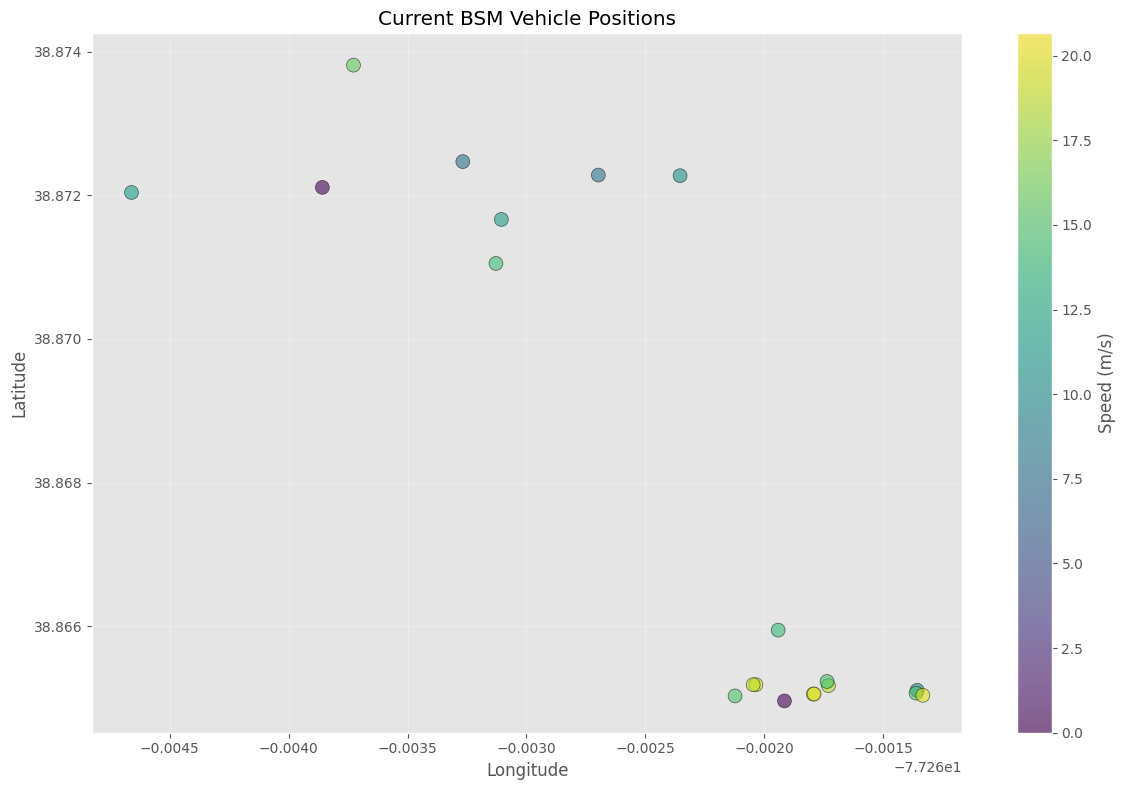

In [11]:
# Visualize BSM vehicle positions
if bsm_messages and len(bsm_data) > 0:
    df_bsm_valid = df_bsm.dropna(subset=['Latitude', 'Longitude'])

    if not df_bsm_valid.empty:
        plt.figure(figsize=(12, 8))
        plt.scatter(df_bsm_valid['Longitude'], df_bsm_valid['Latitude'],
                    c=df_bsm_valid['Speed (m/s)'], cmap='viridis',
                    s=100, alpha=0.6, edgecolors='black')
        plt.colorbar(label='Speed (m/s)')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title('Current BSM Vehicle Positions')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

### Post BSM Message


In [12]:
# Example: Post a BSM message in JSON format
def post_bsm_json(bsm_data):
    """Post a BSM message in JSON format"""
    url = f"{BASE_URL}/api/bsm/json"
    try:
        response = requests.post(url, json=bsm_data, headers=headers)
        response.raise_for_status()
        result = response.json()
        print(f"✓ BSM posted successfully")
        print(f"  Message Count: {result.get('msgCnt')}")
        print(f"  Vehicle ID: {result.get('id')}")
        return result
    except requests.exceptions.RequestException as e:
        print(f"✗ Failed to post BSM: {e}")
        return None


# Example BSM data (minimal required fields)
example_bsm = {
    "coreData": {
        "msgCnt": 1,
        "id": 12345,
        "lat": 38.8732164,
        "lon": -77.2468636
    }
}

# Uncomment to post:
# post_bsm_json(example_bsm)

## 5. PSM API

PSM (Personal Safety Messages) are used for vulnerable road users (pedestrians, cyclists, workers).


In [13]:
# Get current PSM messages
def get_current_psm():
    """Retrieve current PSM messages"""
    url = f"{BASE_URL}/api/psm/current"
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        data = response.json()
        print(f"✓ Retrieved {len(data)} PSM messages")
        return data
    except requests.exceptions.RequestException as e:
        print(f"✗ Failed to get PSM: {e}")
        return []


psm_messages = get_current_psm()

# Parse PSM data
if psm_messages:
    psm_data = []
    for psm in psm_messages[:10]:
        psm_json = psm.get('psmJson', {})
        position = psm_json.get('position', {})

        # Basic type mapping
        type_map = {0: 'unavailable', 1: 'aPEDESTRIAN', 2: 'aPEDALCYCLIST',
                    3: 'aPUBLICSAFETYWORKER', 4: 'anANIMAL'}

        psm_data.append({
            'ID': psm_json.get('id'),
            'Type': type_map.get(psm_json.get('basicType', 0)),
            'Latitude': position.get('lat'),
            'Longitude': position.get('lon'),
            'Speed (m/s)': psm_json.get('speed'),
            'Heading (deg)': psm_json.get('heading'),
            'RSU': psm.get('rsuName'),
            'Timestamp': datetime.fromtimestamp(psm.get('timestamp', 0)/1000).strftime('%Y-%m-%d %H:%M:%S')
        })

    df_psm = pd.DataFrame(psm_data)
    display(df_psm)

✓ Retrieved 3 PSM messages


,ID,Type,Latitude,Longitude,Speed (m/s),Heading (deg),RSU,Timestamp
0,10722,aPEDALCYCLIST,38.864783,-77.262778,4.08,73.2375,From_WebSocket,2025-11-19 13:08:04
1,11439,aPEDESTRIAN,38.865502,-77.261884,1.66,334.1000,From_WebSocket,2025-11-19 13:08:00
2,11436,aPEDESTRIAN,38.865453,-77.261816,1.00,344.5750,From_WebSocket,2025-11-19 13:07:58


## 6. Data Analysis and Visualization


In [14]:
# Summary statistics
print("=== VCC API Data Summary ===")
print(f"\nMapData:")
if 'df_mapdata' in locals():
    print(f"  Total Intersections: {len(df_mapdata)}")
    print(f"  Total Lanes: {df_mapdata['Lane Count'].sum()}")
    print(
        f"  Avg Lanes per Intersection: {df_mapdata['Lane Count'].mean():.1f}")

print(f"\nBSM:")
if 'df_bsm' in locals():
    print(f"  Active Vehicles: {len(df_bsm)}")
    print(
        f"  Avg Speed: {df_bsm['Speed (m/s)'].mean():.2f} m/s ({df_bsm['Speed (m/s)'].mean() * 2.237:.2f} mph)")
    print(f"  Unique RSUs: {df_bsm['RSU'].nunique()}")

print(f"\nPSM:")
if 'df_psm' in locals():
    print(f"  Active VRUs: {len(df_psm)}")
    print(f"  Types: {df_psm['Type'].value_counts().to_dict()}")

=== VCC API Data Summary ===

MapData:
  Total Intersections: 4
  Total Lanes: 85
  Avg Lanes per Intersection: 21.2

BSM:
  Active Vehicles: 20
  Avg Speed: 13.14 m/s (29.40 mph)
  Unique RSUs: 1

PSM:
  Active VRUs: 3
  Types: {'aPEDESTRIAN': 2, 'aPEDALCYCLIST': 1}


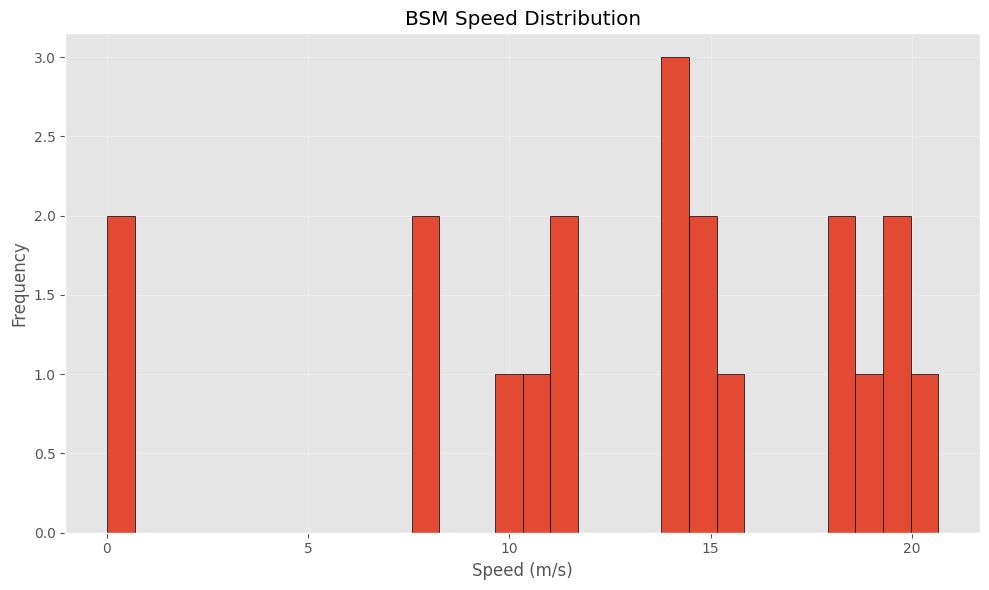

In [15]:
# Speed distribution
if 'df_bsm' in locals() and not df_bsm.empty:
    plt.figure(figsize=(10, 6))
    df_bsm['Speed (m/s)'].dropna().hist(bins=30, edgecolor='black')
    plt.xlabel('Speed (m/s)')
    plt.ylabel('Frequency')
    plt.title('BSM Speed Distribution')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 7. Advanced: WebSocket Data Collection


In [16]:
# Example WebSocket client for BSM
async def collect_bsm_websocket(duration_seconds=30):
    """Collect BSM data via WebSocket for specified duration"""

    # Get WebSocket key
    key_url = f"{BASE_URL}/api/bsm/key"
    response = requests.get(key_url, headers=headers)
    bsm_key = response.content.decode('utf-8')

    # Connect to WebSocket
    uri = f"wss://vcc.vtti.vt.edu/ws/bsm?key={bsm_key}"

    collected_data = []
    start_time = datetime.now()

    try:
        async with websockets.connect(uri) as websocket:
            print(f"✓ Connected to BSM WebSocket")

            while (datetime.now() - start_time).seconds < duration_seconds:
                message = await websocket.recv()
                data = json.loads(message)
                collected_data.extend(data)
                print(
                    f"  Received {len(data)} BSM messages (Total: {len(collected_data)})")

    except Exception as e:
        print(f"✗ WebSocket error: {e}")

    return collected_data

# Uncomment to run:
# bsm_stream_data = await collect_bsm_websocket(30)

## 8. Utility Functions


In [17]:
def decode_base64_message(base64_string):
    """Decode a base64-encoded J2735 message to hex"""
    try:
        decoded = base64.b64decode(base64_string)
        hex_string = decoded.hex().upper()
        return hex_string
    except Exception as e:
        print(f"Failed to decode: {e}")
        return None


def timestamp_to_datetime(timestamp_ms):
    """Convert epoch milliseconds to datetime"""
    return datetime.fromtimestamp(timestamp_ms / 1000)


def meters_per_sec_to_mph(mps):
    """Convert meters per second to miles per hour"""
    return mps * 2.23694 if mps is not None else None


# Example usage
example_base64 = "ABQlGlFAAAAPCiXnuj6drx8/E9MGBgAAcACfWv36H6EAf/+AAPAPAA=="
print(f"Base64: {example_base64}")
print(f"Hex: {decode_base64_message(example_base64)}")
print(f"\n10 m/s = {meters_per_sec_to_mph(10):.2f} mph")

Base64: ABQlGlFAAAAPCiXnuj6drx8/E9MGBgAAcACfWv36H6EAf/+AAPAPAA==
Hex: 0014251A514000000F0A25E7BA3E9DAF1F3F13D30606000070009F5AFDFA1FA1007FFF8000F00F00

10 m/s = 22.37 mph


## Next Steps

1. **Real-time Monitoring**: Set up WebSocket connections for continuous data streaming
2. **Data Storage**: Save collected data to database for historical analysis
3. **Safety Analysis**: Identify potential conflicts between vehicles and VRUs
4. **Traffic Patterns**: Analyze signal timing and traffic flow efficiency
5. **Visualization**: Create interactive maps and dashboards

## Resources

- VCC API Documentation: [VCC_Public_API_v3.1.pdf](../files/VCC_Public_API_v3.1.pdf)
- SAE J2735 Standard: https://www.sae.org/standards/content/j2735_201603/
- ASN.1 Decoder: https://www.marben-products.com/decoder-asn1-automotive
